https://github.com/albumentations-team/albumentations_examples/blob/master/notebooks/example.ipynb

```
            self.composed = transforms.Compose([
                transforms.RandomResizedCrop(param.SZ),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
```

# start

In [1]:
PRFX = 'MelEDA0702A1'
PRFX_PREP = 'MelPrp0629A1'

# setup

In [6]:
import albumentations as A


In [2]:
from pathlib import Path
import pickle
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from PIL import Image
import cv2


In [17]:
import os

import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.color import label2rgb

import albumentations as A
import random

BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)

def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2, **kwargs):
    #height, width = img.shape[:2]

    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    return img

def visualize_titles(img, bbox, title, color=BOX_COLOR, thickness=2, font_thickness = 2, font_scale=0.35, **kwargs):
    #height, width = img.shape[:2]
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    
    ((text_width, text_height), _) = cv2.getTextSize(title, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, title, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, font_scale, TEXT_COLOR,
                font_thickness, lineType=cv2.LINE_AA)
    return img


def augment_and_show(aug, image, mask=None, bboxes=[], categories=[], category_id_to_name=[], filename=None, 
                     font_scale_orig=0.35, 
                     font_scale_aug=0.35, show_title=True, **kwargs):

    augmented = aug(image=image, mask=mask, bboxes=bboxes, category_id=categories)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_aug = cv2.cvtColor(augmented['image'], cv2.COLOR_BGR2RGB)

    for bbox in bboxes:
        visualize_bbox(image, bbox, **kwargs)

    for bbox in augmented['bboxes']:
        visualize_bbox(image_aug, bbox, **kwargs)

    if show_title:
        for bbox,cat_id in zip(bboxes, categories):
            visualize_titles(image, bbox, category_id_to_name[cat_id], font_scale=font_scale_orig, **kwargs)
        for bbox,cat_id in zip(augmented['bboxes'], augmented['category_id']):
            visualize_titles(image_aug, bbox, category_id_to_name[cat_id], font_scale=font_scale_aug, **kwargs)

    
    if mask is None:
        f, ax = plt.subplots(1, 2, figsize=(16, 8))
        
        ax[0].imshow(image)
        ax[0].set_title('Original image')
        
        ax[1].imshow(image_aug)
        ax[1].set_title('Augmented image')
    else:
        f, ax = plt.subplots(2, 2, figsize=(16, 16))
        
        if len(mask.shape) != 3:
            mask = label2rgb(mask, bg_label=0)            
            mask_aug = label2rgb(augmented['mask'], bg_label=0)
        else:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            mask_aug = cv2.cvtColor(augmented['mask'], cv2.COLOR_BGR2RGB)
            
        ax[0, 0].imshow(image)
        ax[0, 0].set_title('Original image')
        
        ax[0, 1].imshow(image_aug)
        ax[0, 1].set_title('Augmented image')
        
        ax[1, 0].imshow(mask, interpolation='nearest')
        ax[1, 0].set_title('Original mask')

        ax[1, 1].imshow(mask_aug, interpolation='nearest')
        ax[1, 1].set_title('Augmented mask')

    f.tight_layout()
    if filename is not None:
        f.savefig(filename)
        
    return augmented['image'], augmented['mask'], augmented['bboxes']

def find_in_dir(dirname):
    return [os.path.join(dirname, fname) for fname in sorted(os.listdir(dirname))]


In [25]:
def augment_and_show(aug, image):
    image = aug(image=image)['image']
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

In [3]:
p_cmp = '../input/siim-isic-melanoma-classification/'
p_prp = f'../output/{PRFX_PREP}'
dftrn = pd.read_csv(f'{p_prp}/train_all.csv') 
dftst = pd.read_csv(f'{p_prp}/test.csv')

../output/MelPrp0629A1/andrewmvd--isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0028130.jpg


(511, 383)

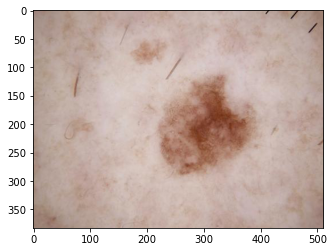

In [4]:
fnm = np.random.choice(dftrn.im_pth)
print(fnm)
x = Image.open(fnm)
plt.imshow(x);
x.size

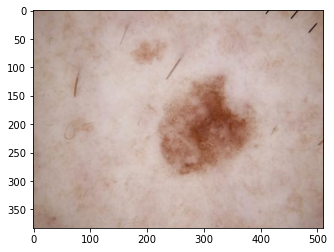

In [30]:
x = cv2.imread(fnm)
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
plt.imshow(x);

# albumentations

## example

In [31]:
image = cv2.imread(fnm)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

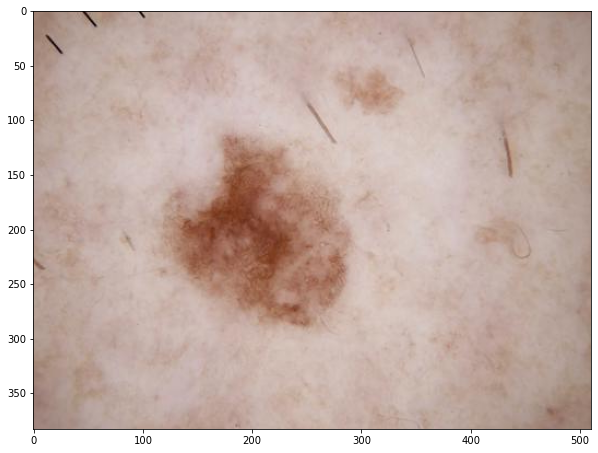

In [33]:
aug = A.HorizontalFlip(p=1)
augment_and_show(aug, image)

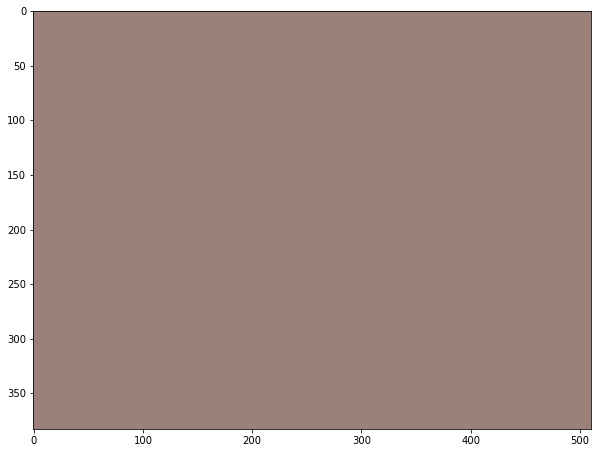

In [34]:
aug = A.IAAPerspective(scale=0.2, p=1)
augment_and_show(aug, image)

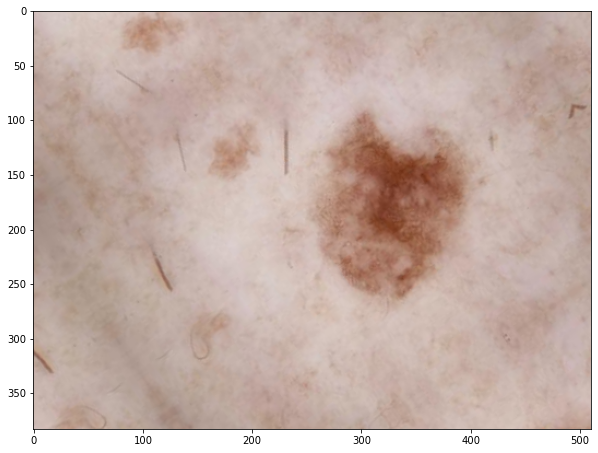

In [36]:
aug = A.ShiftScaleRotate(p=1)
augment_and_show(aug, image)

## Color augmentations

In [20]:
light = A.Compose([
    A.RandomBrightnessContrast(p=1),    
    A.RandomGamma(p=1),    
    A.CLAHE(p=1),    
], p=1)

medium = A.Compose([
    A.CLAHE(p=1),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=50, val_shift_limit=50, p=1),
], p=1)


strong = A.Compose([
    A.ChannelShuffle(p=1),
], p=1)

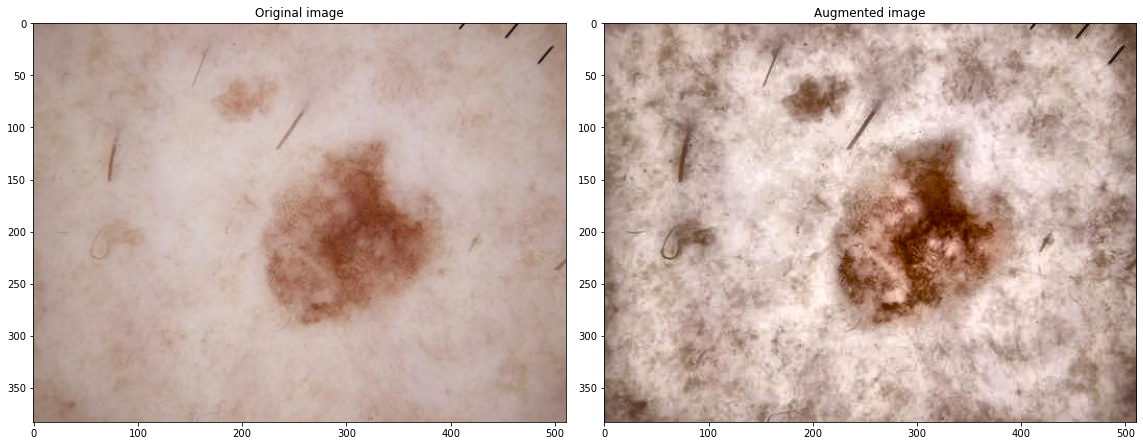

In [21]:
r = augment_and_show(light, image)

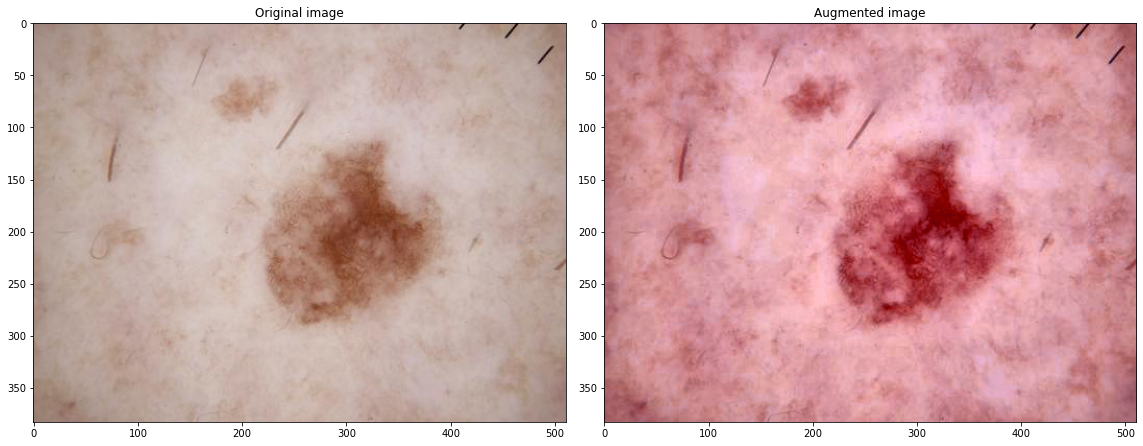

In [22]:
r = augment_and_show(medium, image)

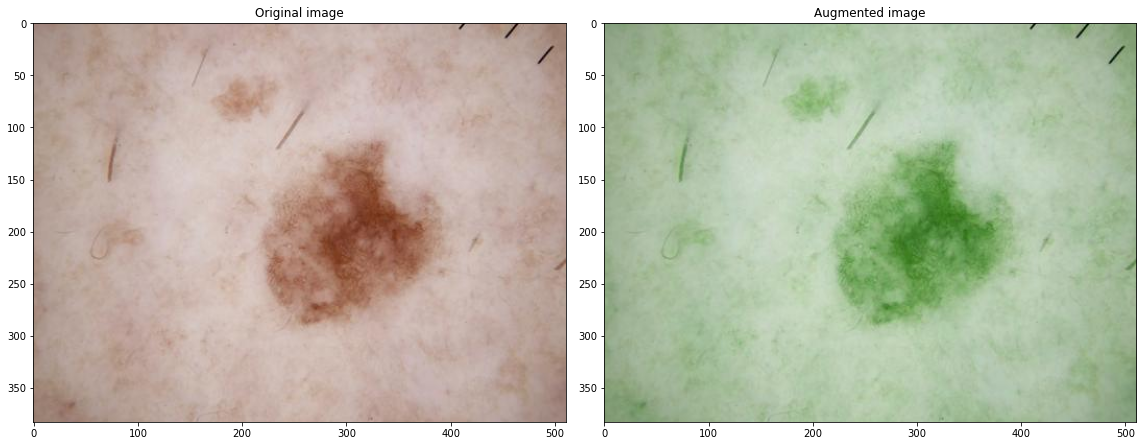

In [24]:
r = augment_and_show(strong, image)

# torchvision

## list

In [107]:
dir(transforms)

['CenterCrop',
 'ColorJitter',
 'Compose',
 'FiveCrop',
 'Grayscale',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'Pad',
 'RandomAffine',
 'RandomApply',
 'RandomChoice',
 'RandomCrop',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomOrder',
 'RandomPerspective',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'functional',
 'transforms']

## resize 

(512, 512)

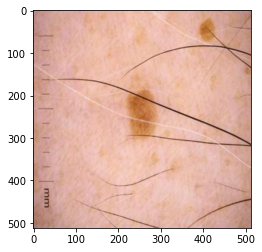

In [94]:
y = transforms.Resize((512, 512))(x)
plt.imshow(y)
y.size

## RandomResizedCrop

(512, 512)

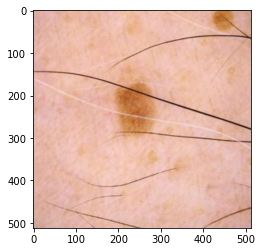

In [98]:
y = transforms.RandomResizedCrop(512)(x)
plt.imshow(y)
y.size

(512, 512)

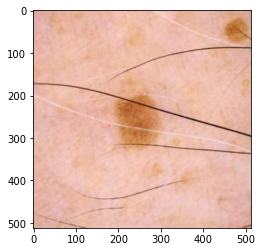

In [179]:
y = transforms.RandomResizedCrop(512, scale=(0.5, 1.0))(x)
plt.imshow(y)
y.size

## RandomRotation

(490, 340)

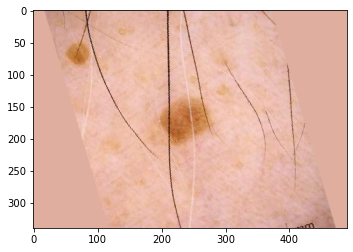

In [167]:
y = transforms.RandomRotation(180,
                              fill=tuple(np.array(x).mean((0,1)).astype(int)))(x)
plt.imshow(y)
y.size

(490, 340)

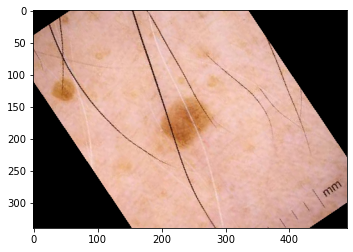

In [102]:
y = transforms.RandomRotation(180)(x)
plt.imshow(y)
y.size

(512, 512)

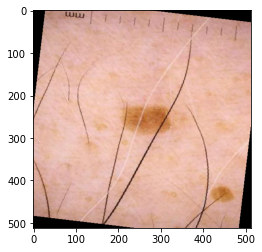

In [202]:
y = transforms.Resize((512, 512))(x)
y = transforms.RandomRotation(180)(y)
plt.imshow(y)
y.size

(512, 512)

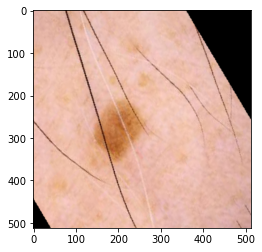

In [203]:
y = transforms.RandomRotation(180)(x)
y = transforms.RandomResizedCrop(512, scale=(0.5, 1.0))(y)
plt.imshow(y)
y.size

(512, 512)

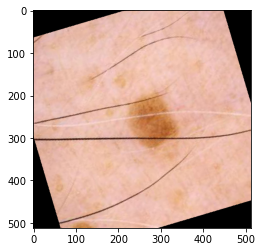

In [207]:
y = transforms.RandomResizedCrop(512, scale=(0.5, 1.0))(x)
y = transforms.RandomRotation(180)(y)
plt.imshow(y)
y.size

## RandomAffine

(490, 340)

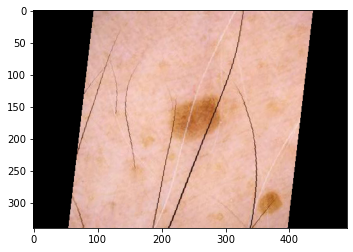

In [141]:
# torchvision.transforms.RandomAffine(degrees, translate=None, scale=None, shear=None, resample=False, fillcolor=0)
y = transforms.RandomAffine(180, shear=40)(x)
plt.imshow(y)
y.size

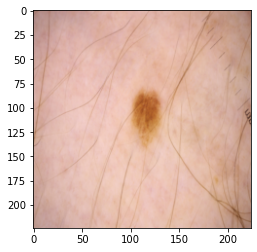

In [73]:
z = transforms.RandomHorizontalFlip()(y)
plt.imshow(z);